# **Overview**

This notebook benchmarks MONAI's implementation of resampling methods against two established repositories - SimpleITK and python itk. In detail:
- we benchmarked MONAI's Transformation and Warping against SimpleITK by reproducing some of the results from the [SimpleITK notebook](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/21_Transforms_and_Resampling.html)
- we benchmarked MONAI's Warping against python itk on a real-world 3d low-pelvic MRI

# **Setup environment**

In [1]:
!pip install -q ipywidgets==7.6
!pip install -q "monai-weekly[nibabel]"
import monai
from monai.apps.utils import download_url

!pip install -q "SimpleITK"
import SimpleITK as sitk

!pip install -q "itk"
import itk

import torch
import os
import tempfile
import PIL
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed

# **Download data**

For comparison against SimpleITK implementation [results](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/21_Transforms_and_Resampling.html), download the SimpleITK logo.

For comparison against python itk, download the lower-pelvic MRI.

In [2]:
# create temporary directory
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

# dict of file name and cooresponding urls
url_dict = {
    "SimpleITK.jpg": "https://s3.amazonaws.com/simpleitk/public/notebooks/SHA512/f1b5ce1bf9d7ebc0bd66f1c3bc0f90d9e9798efc7d0c5ea7bebe0435f173355b27df632971d1771dc1fc3743c76753e6a28f6ed43c5531866bfa2b38f1b8fd46",  # noqa: E501
    "mri.nii": "https://drive.google.com/uc?id=17tsDLvG_GZm7a4fCVMCv-KyDx0hqq1ji"
}

# download and rename
for k, v in url_dict.items():
    download_url(v, f"{root_dir}/{k}")

root dir is: /tmp/tmp3zayeh_u


SimpleITK.jpg: 8.00kB [00:00, 24.9kB/s]

2022-01-20 17:56:19,937 - INFO - Downloaded: /tmp/tmp3zayeh_u/SimpleITK.jpg
2022-01-20 17:56:19,939 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmp3zayeh_u/SimpleITK.jpg.



Downloading...
From: https://drive.google.com/uc?id=17tsDLvG_GZm7a4fCVMCv-KyDx0hqq1ji
To: /tmp/tmp2euy74rf/mri.nii
100%|██████████| 12.1M/12.1M [00:00<00:00, 210MB/s]

2022-01-20 17:56:20,720 - INFO - Downloaded: /tmp/tmp3zayeh_u/mri.nii
2022-01-20 17:56:20,722 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmp3zayeh_u/mri.nii.


# **SimpleITK**

## Transfromation

This section displays the transformation functionalities in an interactive manner. Horizontal and verticle translation, as well as rotation angle could be adjusted by sliding the bars.

In [3]:
def transformation_display(img_path, tx, ty, theta):
    """
    transfrom a image by MOANI and SimpleITK and plot both transformed images
    """

    # monai transform
    monai_img = np.asarray(PIL.Image.open(img_path))
    monai_img = monai_img.transpose((2, 0, 1))
    transform = monai.transforms.Compose([
       monai.transforms.Affined(
           keys=["img"],
           rotate_params=-theta,
           translate_params=(ty, tx),
           padding_mode="zeros"
           ),
       monai.transforms.ScaleIntensityd(keys=["img"])
       ])
    monai_transformed = transform({"img": monai_img})["img"].transpose((1, 2, 0))

    # sitk transform
    sitk_img = sitk.ReadImage(img_path)
    euler2d_transform = sitk.Euler2DTransform()
    euler2d_transform.SetCenter(
        sitk_img.TransformContinuousIndexToPhysicalPoint(
            np.array(sitk_img.GetSize()) / 2.0
            )
        )
    euler2d_transform.SetTranslation((tx, ty))
    euler2d_transform.SetAngle(theta)
    sitk_transformed = sitk.Resample(sitk_img, euler2d_transform)

    # plot monai and sitk transformed results as subplots
    fig, ax = plt.subplots(2)
    ax[0].imshow(monai_transformed)
    ax[0].axis('off')
    ax[0].set_title("MONAI")
    ax[1].imshow(sitk.GetArrayFromImage(sitk_transformed))
    ax[1].axis('off')
    ax[1].set_title("SimpleITK")
    plt.show()


# generate the interactive display
interact(
    transformation_display,
    img_path=fixed(f"{root_dir}/SimpleITK.jpg"),
    tx=(-128.0, 128.0, 2.0),
    ty=(-64.0, 64.0),
    theta=(-np.pi/4.0, np.pi/4.0)
)

interactive(children=(FloatSlider(value=0.0, description='tx', max=128.0, min=-128.0, step=2.0), FloatSlider(v…

## Warping

Warping distorts an `image` by `ddf` to give the `output`.

The following example randomly sample 10 physical points (locations) on an image and assign ascending displacements in y(H) direction accordingly.
Resampled intensities obtained by both MONAI and SimpleITK implementations are reported at all 10 points.

First, 10 physical points are randomly sampled from the downloaded SimpleITK logo.

In [4]:
# Read image
img_path = f"{root_dir}/SimpleITK.jpg"
monai_img = np.asarray(PIL.Image.open(img_path))
monai_img = monai_img.transpose((2, 0, 1))
monai_img = torch.tensor(monai_img, dtype=torch.float)
sitk_img = sitk.ReadImage(img_path)

width, height = sitk_img.GetSize()

# Generate random samples inside the image, we will obtain the intensity/color values at these points.
num_samples = 10
physical_points = np.array([np.random.randint(monai_img.shape[1:]) for _ in range(10)], dtype=np.float)  # (10, 2)


Currently, only spatial (4-D) and volumetric (5-D) input are supported by MONAI. In the following spatial (4-D) example, for an `image` of shape (batch, num_channels, H, W) and a `ddf` of shape (batch, 2, H, W), the output will have the same shape as `input`.

For each output location `output[b, :, h, w]`, the size-2 vector `ddf[b, :, h, w] = [h', w']` specifies coordinate displacement in y(H) and x(W) direaction from the input location `image[b, :, h, w]`. In other words, the value at `output[b, :, h, w]` should correspond to the value at `input[b, :, h + h', w + w']`

In [5]:
# initialise ddf as a zero matrix
ddf = torch.zeros(2, height, width).to(torch.float)  # (2, H, W)
# add displacement of y coordinate to sampled locations
for i, pnt in enumerate(physical_points.astype(np.long)):
    ddf[0, pnt[0], pnt[1]] += i

# initialise warp layer
warp = monai.networks.blocks.Warp(mode='bilinear', padding_mode='zeros')

# warp, note an batch dimension is added and removed during calculation
monai_resample = warp(
    monai_img.unsqueeze(0), ddf.unsqueeze(0).to(monai_img)).squeeze(0)  # (3, H, W)

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


The same operation could be achived by the `Resample` method from SimpleITK. SimpleITK's procedural API provides three methods for performing resampling. Here we use 

`Resample(const Image &image1, const Image &referenceImage, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)`

In [6]:
# Create an image of size [width, height]. The pixel type is irrelevant, as the image is 
# just defining the interpolation grid (sitkUInt8 has minimal memory footprint).
interp_grid_img = sitk.Image([width, height], sitk.sitkUInt8)

# initialise displacement
sitk_displacement_img = sitk.Image([width, height], sitk.sitkVectorFloat64, sitk_img.GetDimension())
# add displacement of y coordinate to sampled locations
for i, pnt in enumerate(physical_points):
    sitk_displacement_img[int(pnt[1]), int(pnt[0])] = np.array([0, i], dtype=np.float)

# select linear interpolater to match `bilinear` mode in MONAI
interpolator_enum = sitk.sitkLinear
# set default_output_pixel_value to 0.0 to match `zero` padding_mode in MONAI
default_output_pixel_value = 0.0
# set output_pixel_type
output_pixel_type = sitk.sitkVectorFloat32
# resample
sitk_resample = sitk.Resample(
    sitk_img,
    interp_grid_img,
    sitk.DisplacementFieldTransform(sitk_displacement_img),
    interpolator_enum,
    default_output_pixel_value,
    output_pixel_type
    )

# turn resampled image into numpy array for later comparison
sitk_resample = sitk.GetArrayFromImage(sitk_resample)

Compare results from MONAI and SimpleITK. As could be observed, same intensities are predicted by both MONAI and SimpleITK implementation at all 10 points.

In [7]:
for i, pnt in enumerate(physical_points.astype(np.long)):
    print(f"at location {pnt}: original intensity {monai_img[:, pnt[0], pnt[1]]} " +
          f"resampled to {monai_resample[:, pnt[0], pnt[1]]} by MONAI and {sitk_resample[pnt[0], pnt[1]]} by SITK")

at location [ 16 171]: original intensity tensor([252., 255., 250.]) resampled to tensor([252., 255., 250.]) by MONAI and [252. 255. 250.] by SITK
at location [49 66]: original intensity tensor([198., 133.,  29.]) resampled to tensor([199., 135.,  37.]) by MONAI and [199. 135.  37.] by SITK
at location [ 5 58]: original intensity tensor([255., 255., 255.]) resampled to tensor([255., 255., 255.]) by MONAI and [255. 255. 255.] by SITK
at location [  5 181]: original intensity tensor([255., 255., 255.]) resampled to tensor([255., 255., 255.]) by MONAI and [255. 255. 255.] by SITK
at location [14  4]: original intensity tensor([255., 255., 255.]) resampled to tensor([255., 255., 255.]) by MONAI and [255. 255. 255.] by SITK
at location [ 27 152]: original intensity tensor([251., 255., 255.]) resampled to tensor([252., 255., 253.]) by MONAI and [252. 255. 253.] by SITK
at location [ 17 145]: original intensity tensor([228., 236., 247.]) resampled to tensor([ 43.,  87., 150.]) by MONAI and [ 

# **python itk**
## Warping

In this example, we generate a random dense displacemeny field, and use it to warp the downloaded 3d lower-pelvic MRI with both MONAI's `Warp` layer and python itk's `warpFilter`.

Firstly, we read the nifti file using MONAI's I/O.

In [8]:
img = monai.transforms.LoadImaged(keys="img")({"img": f"{root_dir}/mri.nii"})["img"]
# W, H, D -> D, H, W
img = img.transpose((2, 1, 0))

Secondly, we generate a random dense displacement field with maximum displacement in each direction equals to one-tenth of the image dimension in that direction.

In [9]:
ddf = np.random.random((3, *img.shape)).astype(np.float32)  # (3, D, H, W)
ddf[0] = ddf[0] * img.shape[0] * 0.1
ddf[1] = ddf[1] * img.shape[1] * 0.1
ddf[2] = ddf[2] * img.shape[2] * 0.1

Warp with MONAI.

In [10]:
# initialise warp layer
warp_layer = monai.networks.blocks.Warp(padding_mode="zeros")

# turn image and ddf to tensor, add channel dim to image
monai_img = torch.tensor(img).unsqueeze(0)
monai_ddf = torch.tensor(ddf)

# warp, note an batch dimension is added and removed during calculation
monai_warped_img = warp_layer(monai_img.unsqueeze(0), monai_ddf.unsqueeze(0)).squeeze(0)

# remove channel dim and transform to numpy array
monai_warped_img = np.asarray(monai_warped_img.squeeze(0))

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


Warp with python itk.

In [11]:
Dimension = 3

# initialise image
PixelType = itk.F  # similar to np.float32
ImageType = itk.Image[PixelType, Dimension]
# cast image to ImageType
itk_img = itk.PyBuffer[ImageType].GetImageFromArray(
    img.astype(np.float32), is_vector=None)

# initialise displacement
VectorComponentType = itk.F  # similar to np.float32
VectorPixelType = itk.Vector[VectorComponentType, Dimension]
DisplacementFieldType = itk.Image[VectorPixelType, Dimension]
# 3, D, H, W -> D, H, W, 3
itk_ddf = ddf.transpose((1, 2, 3, 0))
# x, y, z -> z, x, y
itk_ddf = itk_ddf[..., ::-1]
# cast ddf to DisplacementFieldType
deformationField = itk.PyBuffer[DisplacementFieldType].GetImageFromArray(
    itk_ddf.astype(np.float32), is_vector=True)
# initialise warpFilter, set input, output and displacement field types
warpFilter = itk.WarpImageFilter[ImageType, ImageType, DisplacementFieldType].New()
# set interpolator
interpolator = itk.LinearInterpolateImageFunction[ImageType, itk.D].New()
warpFilter.SetInterpolator(interpolator)
# set output spacing, origin and direction
warpFilter.SetOutputSpacing(itk_img.GetSpacing())
warpFilter.SetOutputOrigin(itk_img.GetOrigin())
warpFilter.SetOutputDirection(itk_img.GetDirection())
# warp
warpFilter.SetDisplacementField(deformationField)
warpFilter.SetInput(itk_img)
itk_warped_img = warpFilter.GetOutput()

# transfrom itk.Image to numpy array
itk_warped_img = np.asarray(itk_warped_img)

Visualise the original image, and two warped image by MONAi and python itk.

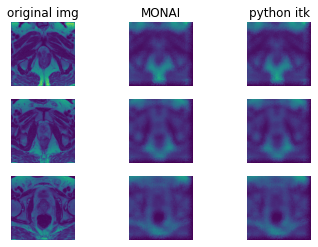

In [12]:
fig, ax = plt.subplots(3, 3)
for i, (row, d) in enumerate(zip(ax, [5, 10, 15])):
    row[0].imshow(img[d])
    row[0].axis('off')
    row[1].imshow(monai_warped_img[d])
    row[1].axis('off')
    row[2].imshow(itk_warped_img[d])
    row[2].axis('off')

    if i == 0:
        row[0].set_title("original img")
        row[1].set_title("MONAI")
        row[2].set_title("python itk")
plt.show()

Quantitatively calcaluate the mean relative difference between results obtained by MONAI and python itk. As could be shown, the mean relative difference is below 1%.

In [13]:
np.mean(
    np.divide(
        itk_warped_img - monai_warped_img,
        itk_warped_img,
        out=np.zeros_like(itk_warped_img),
        where=itk_warped_img != 0
    )
)

0.0054110507